# Heliport Tespit Etme

<table><tr><td>Test Verisi</td><td>Eğitim (Train) Verisi</td><td>Eğitim Adımı (Epoch)</td></tr><tr><td>58</td><td>228</td><td>28538</td></tr></table>

# Kullanılan Kütüphaneler

In [1]:
import numpy as np
import os
import six.moves.urllib as urllib
import sys
import tarfile
import tensorflow as tf
import zipfile

from distutils.version import StrictVersion
from collections import defaultdict
from io import StringIO
from matplotlib import pyplot as plt
from PIL import Image

sys.path.append("..")
from object_detection.utils import ops as utils_ops

if StrictVersion(tf.__version__) < StrictVersion('1.9.0'):
  raise ImportError('TensorFlow sürümünüz v1.9.* veya üstü olmalı!')


In [2]:
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as vis_util

C:\Users\Nano\AppData\Local\conda\conda\envs\keras\lib\site-packages\object_detection-0.1-py3.6.egg\object_detection\utils\visualization_utils.py:27: UserWarning: matplotlib.pyplot as already been imported, this call will have no effect.
  import matplotlib; matplotlib.use('Agg')  # pylint: disable=multiple-statements


## Resimlerin Gösterimi

In [3]:
%matplotlib inline

# Eğitilmiş Modelin Hazırlanması

In [4]:
# Modelin Yüklenmesi.
MODEL_NAME = 'C:/Users/Nano/pyNotebooks/HeliportDetection/faster_rcnn_inception_v2_coco_2018_01_28'

# eğitilmiş veriden elde edilen frozen graph'ın entegrasyonu
PATH_TO_FROZEN_GRAPH = 'C:/Users/Nano/pyNotebooks/HeliportDetection/faster_rcnn_inception_v2_coco_2018_01_28/frozen_inference_graph.pb'

# Sınıfa ait Etiket. "Heliport"
PATH_TO_LABELS = os.path.join('C:/Users/Nano/pyNotebooks/HeliportDetection/data', 'labelmap.pbtxt')

## Frozen Graph'ın TF'e aktarılması

In [5]:
detection_graph = tf.Graph()
with detection_graph.as_default():
  od_graph_def = tf.GraphDef()
  with tf.gfile.GFile(PATH_TO_FROZEN_GRAPH, 'rb') as fid:
    serialized_graph = fid.read()
    od_graph_def.ParseFromString(serialized_graph)
    tf.import_graph_def(od_graph_def, name='')

## Label map'in yüklenmesi

In [6]:
category_index = label_map_util.create_category_index_from_labelmap(PATH_TO_LABELS, use_display_name=True)

## Piksellerin Matrise Dönüştürülmesi

In [7]:
def load_image_into_numpy_array(image):
  (im_width, im_height) = image.size
  return np.array(image.getdata()).reshape(
      (im_height, im_width, 3)).astype(np.uint8)

# Tespit Etme

In [8]:
# Test_Images klasöründen test için 2 resim çekildi.
# image1.jpg
# image2.jpg

PATH_TO_TEST_IMAGES_DIR = 'test_images'
TEST_IMAGE_PATHS = [ os.path.join(PATH_TO_TEST_IMAGES_DIR, 'IMAGE ({}).jpg'.format(i)) for i in range(1, 4) ]

IMAGE_SIZE = (12, 8)

In [9]:
def run_inference_for_single_image(image, graph):
  with graph.as_default():
    with tf.Session() as sess:
      ops = tf.get_default_graph().get_operations()
      all_tensor_names = {output.name for op in ops for output in op.outputs}
      tensor_dict = {}
      for key in [
          'num_detections', 'detection_boxes', 'detection_scores',
          'detection_classes', 'detection_masks'
      ]:
        tensor_name = key + ':0'
        if tensor_name in all_tensor_names:
          tensor_dict[key] = tf.get_default_graph().get_tensor_by_name(
              tensor_name)
      if 'detection_masks' in tensor_dict:
        detection_boxes = tf.squeeze(tensor_dict['detection_boxes'], [0])
        detection_masks = tf.squeeze(tensor_dict['detection_masks'], [0])
        real_num_detection = tf.cast(tensor_dict['num_detections'][0], tf.int32)
        detection_boxes = tf.slice(detection_boxes, [0, 0], [real_num_detection, -1])
        detection_masks = tf.slice(detection_masks, [0, 0, 0], [real_num_detection, -1, -1])
        detection_masks_reframed = utils_ops.reframe_box_masks_to_image_masks(
            detection_masks, detection_boxes, image.shape[0], image.shape[1])
        detection_masks_reframed = tf.cast(
            tf.greater(detection_masks_reframed, 0.5), tf.uint8)
        tensor_dict['detection_masks'] = tf.expand_dims(
            detection_masks_reframed, 0)
      image_tensor = tf.get_default_graph().get_tensor_by_name('image_tensor:0')

      output_dict = sess.run(tensor_dict,
                             feed_dict={image_tensor: np.expand_dims(image, 0)})

      output_dict['num_detections'] = int(output_dict['num_detections'][0])
      output_dict['detection_classes'] = output_dict[
          'detection_classes'][0].astype(np.uint8)
      output_dict['detection_boxes'] = output_dict['detection_boxes'][0]
      output_dict['detection_scores'] = output_dict['detection_scores'][0]
      if 'detection_masks' in output_dict:
        output_dict['detection_masks'] = output_dict['detection_masks'][0]
  return output_dict

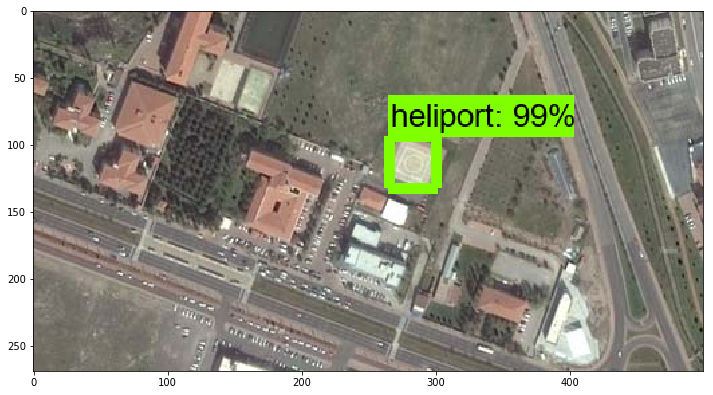

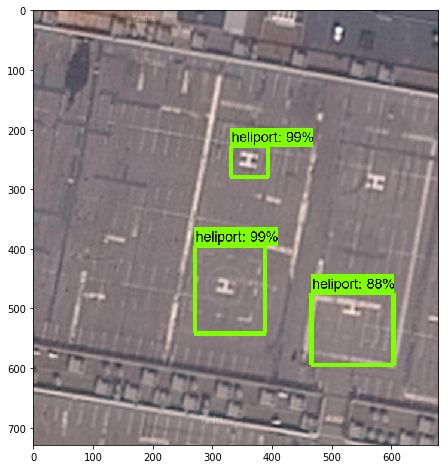

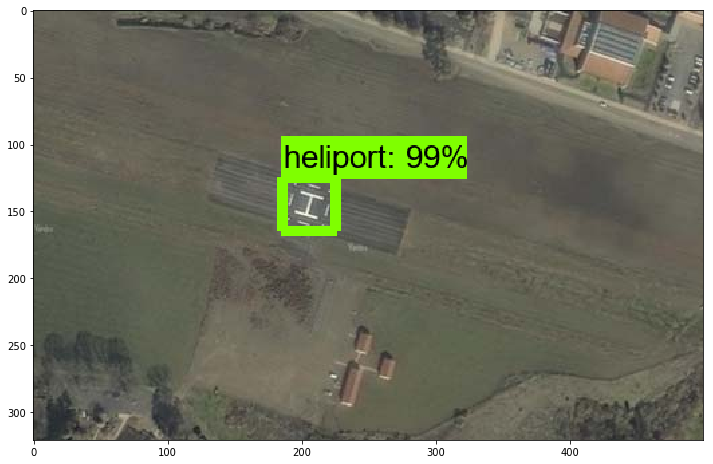

In [10]:
for image_path in TEST_IMAGE_PATHS:
    image = Image.open(image_path)
    image_np = load_image_into_numpy_array(image)
    image_np_expanded = np.expand_dims(image_np, axis=0)
    output_dict = run_inference_for_single_image(image_np, detection_graph)

    vis_util.visualize_boxes_and_labels_on_image_array(
        image_np,
        output_dict['detection_boxes'],
        output_dict['detection_classes'],
        output_dict['detection_scores'],
        category_index,
        instance_masks=output_dict.get('detection_masks'),
        use_normalized_coordinates=True,
        line_thickness=8)
    plt.figure(figsize=IMAGE_SIZE)
    plt.imshow(image_np)    